In [223]:
import os, requests, zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import scipy.stats as ss
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [79]:
#!pip install plotly
#!pip install "notebook>=5.3" "ipywidgets>=7.2"

# Goal


Using the data collected from existing customers, build a model that will help the marketing
team identify potential customers who are relatively more likely to subscribe term deposit
and thus increase their hit ratio.

**Resources Available**
The historical data for this project is available in file
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [8]:
##download data

### creates a directory for the project, if it not exists
def downloadData():

    if not os.path.exists('bankmarketing'):
        os.makedirs('bankmarketing')
    os.chdir(str(os.getcwd())+'/bankmarketing')

    ### download raw data
    r = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip')
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

    ## check downloaded data
    os.listdir()

In [10]:
downloadData()

In [22]:
## load data
def loadData():
    return pd.read_csv('bank-additional-full.csv', sep=';')


pd_bank_full_raw = loadData()

Les's take a look at data to see if it`s import worked suscessfully

In [18]:
pd_bank_full_raw.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

**Accordly to documentation, this is how data should look like**
    
1. age: Continuous feature
2. job: Type of job (management, technician, entrepreneur, blue-collar, etc.)
3. marital: marital status (married, single, divorced)
4. education: education level (primary, secondary, tertiary)
5. default: has credit in default?
6. housing: has housing loan?
7. loan: has personal loan?
8. balance in account
9. contact: contact communication type
10. month: last contact month of year
11. day: last contact day of the month
12. duration: last contact duration, in seconds*
13. campaign: number of contacts performed during this campaign and for this client
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (-1 tells us the person has not been contacted or contact period is beyond 900 days)
15. previous: number of contacts performed before this campaign and for this client
16. poutcome: outcome of the previous marketing campaign
17. Target: Tell us has the client subscribed a term deposit. (Yes, No)


**But since I downlowaded from UCI repository, I'll only keep those fields that are important.**

In [23]:
pd_bank_full_raw.drop(columns=['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'], inplace=True)
pd_bank_full_raw.rename(columns={"y":"target"}, inplace=True)
pd_bank_full_raw.dtypes


age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
target         object
dtype: object

## EDA

**1 - Checking for missing data**

In [35]:
missing_values = pd_bank_full_raw.isnull().sum() / len(pd_bank_full_raw)

In [26]:
missing_values

age            0.0
job            0.0
marital        0.0
education      0.0
default        0.0
housing        0.0
loan           0.0
contact        0.0
month          0.0
day_of_week    0.0
duration       0.0
campaign       0.0
pdays          0.0
previous       0.0
poutcome       0.0
target         0.0
dtype: float64

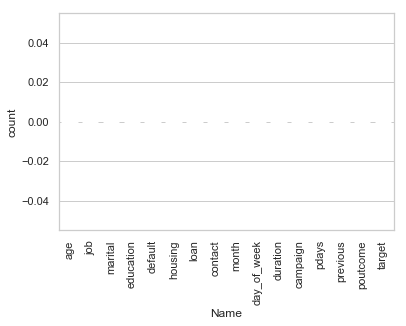

In [36]:
missing_values = missing_values.to_frame()
missing_values.columns = ['count']
missing_values.index.names = ['Name']

sns.set(style="whitegrid", color_codes=True)
sns.barplot(x=missing_values.index, y='count', data=missing_values)
plt.xticks(rotation=90)
plt.show()

Good. No missing data for the whole dataframe.

**2 - Verifying numerical data**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2a97dbe0>,
      dtype=object)

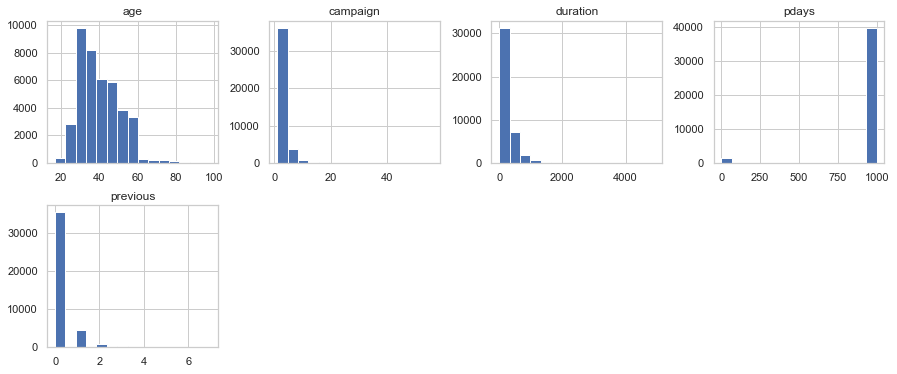

In [37]:
numerical = pd_bank_full_raw[['age','duration','campaign', 'pdays', 'previous']]

numerical.hist(bins=15, figsize=(15,6), layout=(2,4))

So we then have:
 - age values are concetrate between 20 and 80. Makes sense;
 - campaign range is >0 and < 20;
 - Duration range is >0 and < 1200;
 - pdays has or several values or low values. It's like a categorical variable;
 - previous has values of 0, 1 and 2. 

In [41]:
numerical.describe()

Name,age,duration,campaign,pdays,previous
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963
std,10.42125,259.279249,2.770014,186.910907,0.494901
min,17.00000,0.000000,1.000000,0.000000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000


Ok, so for numerical data, apparently there is no big problem on it, like outliers, missing data or even discrepant values.

**2 - Checking Categorical Data**

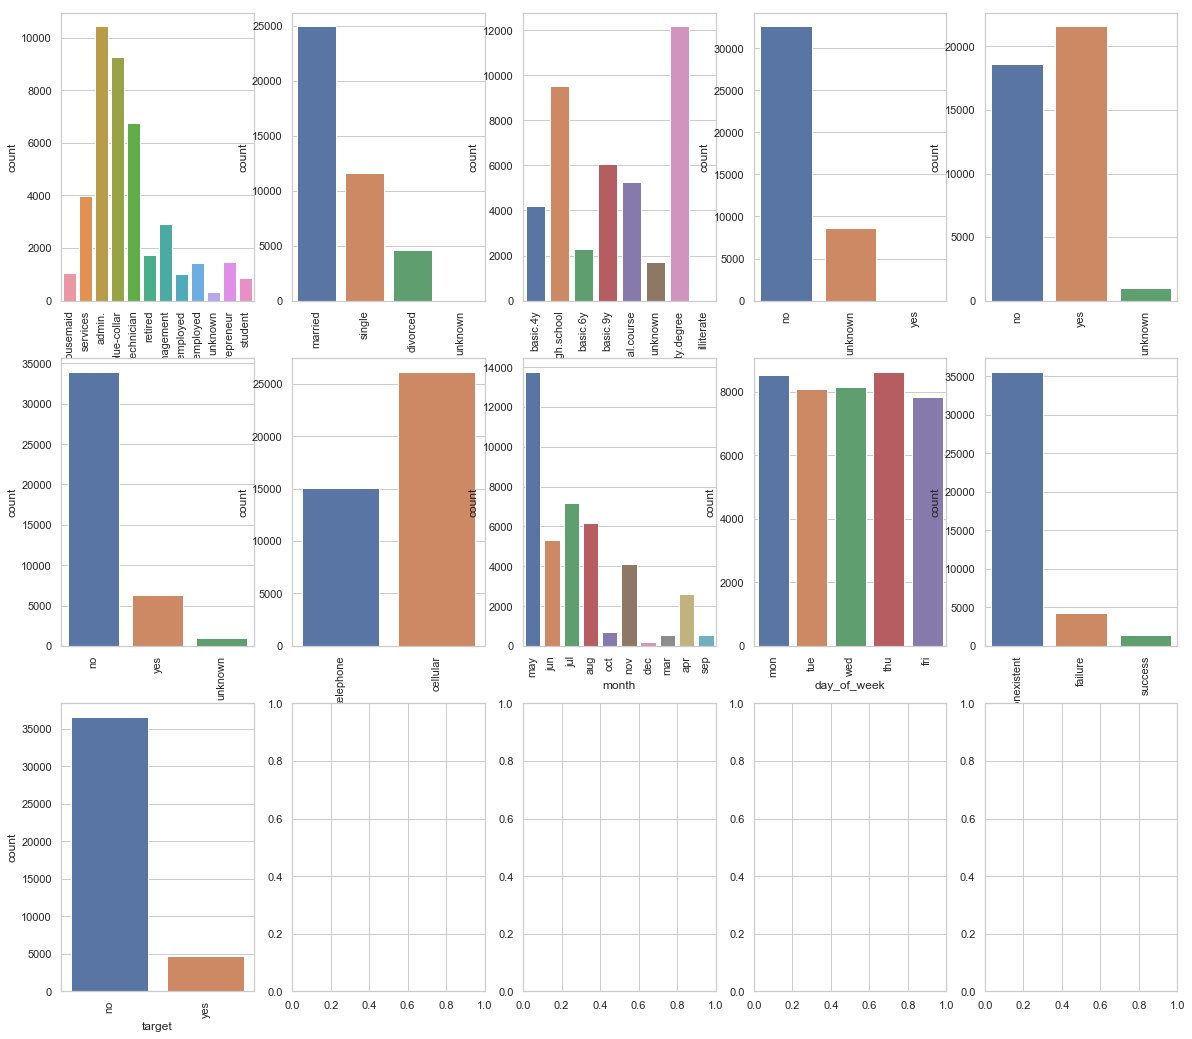

In [228]:
cat_data = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month', 
                             'day_of_week', 'poutcome' , 'target']

fig, ax = plt.subplots(3,5, figsize=(20,18))

for variable, subplot in zip(cat_data, ax.flatten()):
    sns.countplot(pd_bank_full_raw[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Categorical data seens to be very concise. We have some categorical variables with the unknown class.

Notice that target variable is very inbalanced. It may imply in trouble in the future.

**3 - Lets now compare numerical variable with target variable**

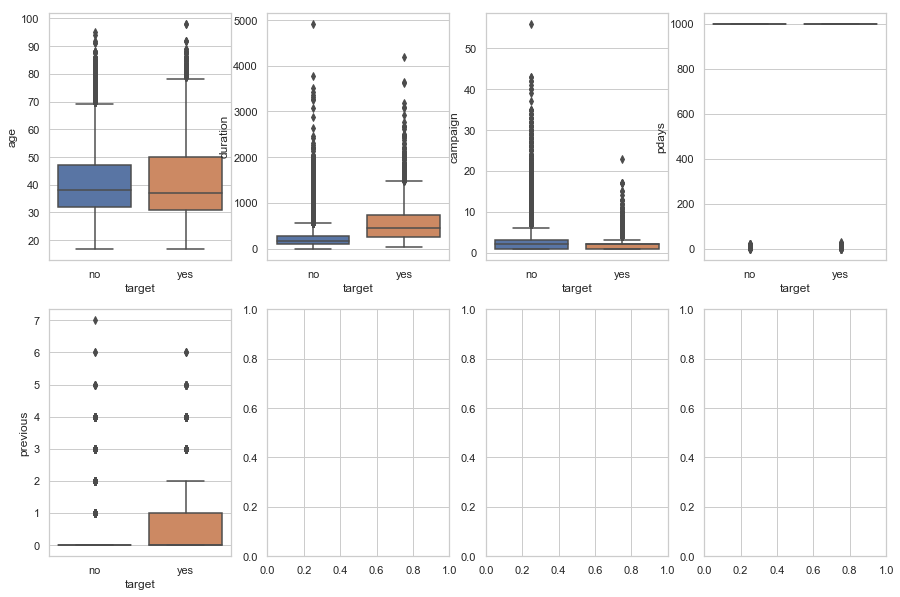

In [58]:
numvar = ['age','duration','campaign', 'pdays', 'previous']
fix, ax = plt.subplots(2,4, figsize=(15,10))

for var, subplot in zip(numvar, ax.flatten()):
    sns.boxplot(x='target', y=var, data=pd_bank_full_raw, ax=subplot)

So far, this plot can show us which is the most important numerical variable against our target variable. By these box plot we can see that the duration has the most different medians between all plots.

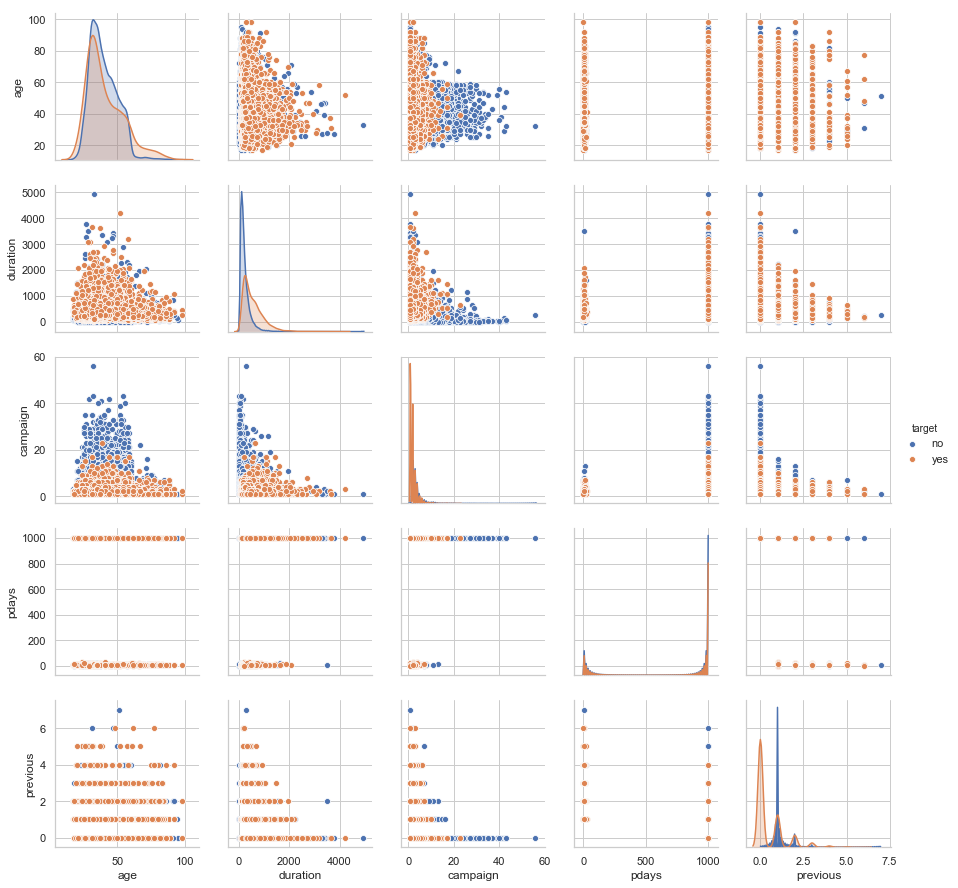

In [62]:
sns.pairplot(pd_bank_full_raw[['age','duration','campaign', 'pdays', 'previous','target']], hue='target')

But the plot above is more straighforward to understand that some pairwise numerical variables has a difference between target. Number of campaigns seems to be very promising. Lets check.

In [63]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [114]:
flow_data = pd_bank_full_raw.groupby(['target','marital','job','education'], as_index=False).agg({'housing':'count'})


fig = genSankey(flow_data,cat_cols=['target','marital','job','education'],value_cols='housing',title='Flow from categoricals')

ax = go.Figure(fig)
ax.show()

The chart above show how some of categorical variables have relationship with our target variable. By this plot there is no strong stream that can make us to be right of a good correlation between them.

In [121]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

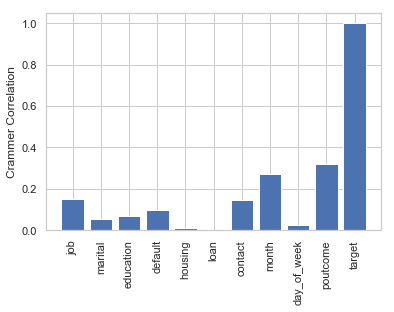

In [152]:
crammer_corr = []
for var in cat_data:
    x = cramers_v(pd_bank_full_raw[var], pd_bank_full_raw['target'])
    crammer_corr.append(x)

plt.bar(cat_data, crammer_corr)
plt.ylabel('Crammer Correlation')
plt.xticks(rotation=90)
plt.show()

By the plot above we can see that the greatest crammer correlation is for **month** and **poutcome** variables.

## Data Preparation

So far we just did small data preparation: checked on missing values, checked on datatype. Now we`re going to prepare our data for the ensemble techniques.

In [144]:
pd_bank_full_raw.head()

Name,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,no


All right, this small look in data show that we have to convert several categorical data into dummies. 

In [153]:
df_stage_banking = pd.get_dummies(pd_bank_full_raw, columns=cat_data[:-1])

In [154]:
df_stage_banking.head()

,age,duration,campaign,pdays,previous,target,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,no,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,no,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,no,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,no,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,no,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [162]:
df_stage_banking.shape

(41188, 59)

Normalizing data and Spliting base into train / test

In [159]:
y = df_stage_banking.target
df_model = df_stage_banking.drop(['target'], axis=1)

scaler = MinMaxScaler()
scaler.fit(df_model)
X = scaler.transform(df_model)

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

/Users/reinaldodeoliveiramaciel/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.



In [161]:
X_train.shape

(28831, 58)

In [163]:
X_test.shape

(12357, 58)

## Create the ensemble model

Before using an ensemble model, I'll run a decision tree, just because it`s a simple classifier and I want it as a baseline to check if the performance of a ensemble model is better.

In [166]:
##Decision tree model
clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_train,y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.875455207574654


So, by the number below it`s easy to see that our tree are just overfitting train data. Let`s limit the depth of the tree.

In [168]:
clf = DecisionTreeClassifier(random_state=1, max_depth=5)
clf.fit(X_train,y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9130103014116749
0.9072590434571498


Much better now. A improve on test data show that the model is generalizing better. Let`s see confusion matrix

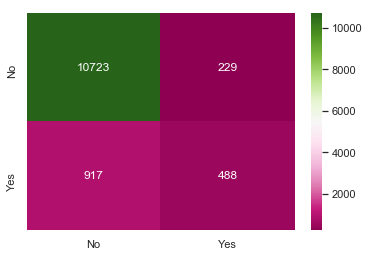

In [184]:
y_predict = clf.predict(X_test)

cm= pd.DataFrame(metrics.confusion_matrix(y_test, y_predict), columns=['No','Yes'], index=['No','Yes'])


sns.heatmap(cm, annot=True, fmt='d', cmap="PiYG")

In [202]:
print('Accuracy of the model:', metrics.accuracy_score(y_test, y_predict))
k = {'no':0, 'yes':1}
print('Precision of the model:', metrics.precision_score([k[y] for y in y_test], [k[y1] for y1 in y_predict]))
print('Recall of the model:', metrics.recall_score([k[y] for y in y_test], [k[y1] for y1 in y_predict]))

Accuracy of the model: 0.9072590434571498
Precision of the model: 0.6806136680613668
Recall of the model: 0.34733096085409254


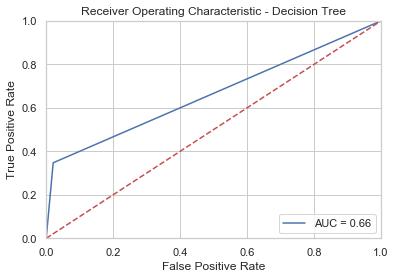

In [207]:
fpr, tpr, threshold = metrics.roc_curve([k[y] for y in y_test], [k[y1] for y1 in y_predict])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - Decision Tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

At this point we can see that this decision tree is just a little better than random. Let`s then check it out the ensemble models.

**Bagging**

In [209]:
##bagging

bgcl = BaggingClassifier(base_estimator=clf, n_estimators=100, random_state=1)

bgcl = bgcl.fit(X_train, y_train)

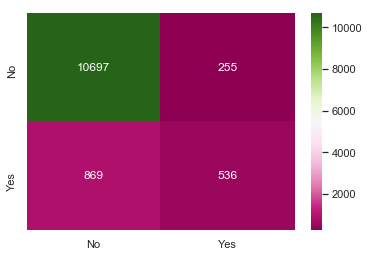

In [210]:
y_predict = bgcl.predict(X_test)

cm= pd.DataFrame(metrics.confusion_matrix(y_test, y_predict), columns=['No','Yes'], index=['No','Yes'])


sns.heatmap(cm, annot=True, fmt='d', cmap="PiYG")

In [211]:
print('Accuracy of the model:', metrics.accuracy_score(y_test, y_predict))
k = {'no':0, 'yes':1}
print('Precision of the model:', metrics.precision_score([k[y] for y in y_test], [k[y1] for y1 in y_predict]))
print('Recall of the model:', metrics.recall_score([k[y] for y in y_test], [k[y1] for y1 in y_predict]))

Accuracy of the model: 0.9090394108602412
Precision of the model: 0.6776232616940582
Recall of the model: 0.38149466192170817


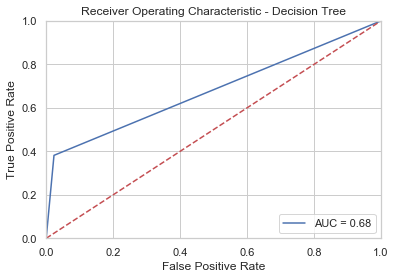

In [212]:
fpr, tpr, threshold = metrics.roc_curve([k[y] for y in y_test], [k[y1] for y1 in y_predict])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - Bagging')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Using como basic classifier our first decision tree, this bagging was not too efficient. Lets see how adaboost behaves.

**Adaboost**

In [214]:
abcl = AdaBoostClassifier(n_estimators=20, random_state=1)
abcl = abcl.fit(X_train, y_train)

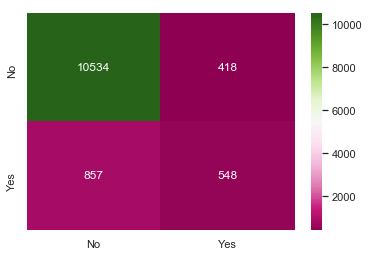

In [215]:
y_predict = abcl.predict(X_test)

cm= pd.DataFrame(metrics.confusion_matrix(y_test, y_predict), columns=['No','Yes'], index=['No','Yes'])

sns.heatmap(cm, annot=True, fmt='d', cmap="PiYG")

In [216]:
print('Accuracy of the model:', metrics.accuracy_score(y_test, y_predict))
k = {'no':0, 'yes':1}
print('Precision of the model:', metrics.precision_score([k[y] for y in y_test], [k[y1] for y1 in y_predict]))
print('Recall of the model:', metrics.recall_score([k[y] for y in y_test], [k[y1] for y1 in y_predict]))

Accuracy of the model: 0.8968196164117505
Precision of the model: 0.567287784679089
Recall of the model: 0.3900355871886121


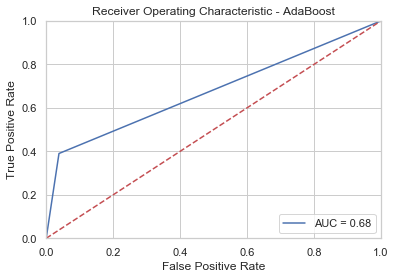

In [217]:
fpr, tpr, threshold = metrics.roc_curve([k[y] for y in y_test], [k[y1] for y1 in y_predict])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - AdaBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This Adaboosting model was very similar to bagging.

**GradientBoost**

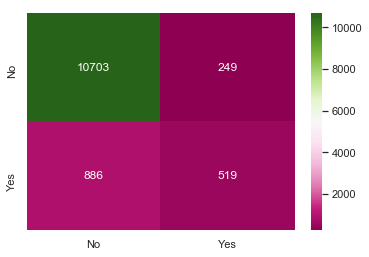

In [219]:
gbcl = GradientBoostingClassifier(n_estimators = 50,random_state=1)
gbcl = gbcl.fit(X_train, y_train)

y_predict = gbcl.predict(X_test)
cm= pd.DataFrame(metrics.confusion_matrix(y_test, y_predict), columns=['No','Yes'], index=['No','Yes'])
sns.heatmap(cm, annot=True, fmt='d', cmap="PiYG")

In [220]:
print('Accuracy of the model:', metrics.accuracy_score(y_test, y_predict))
k = {'no':0, 'yes':1}
print('Precision of the model:', metrics.precision_score([k[y] for y in y_test], [k[y1] for y1 in y_predict]))
print('Recall of the model:', metrics.recall_score([k[y] for y in y_test], [k[y1] for y1 in y_predict]))

Accuracy of the model: 0.9081492271586955
Precision of the model: 0.67578125
Recall of the model: 0.3693950177935943


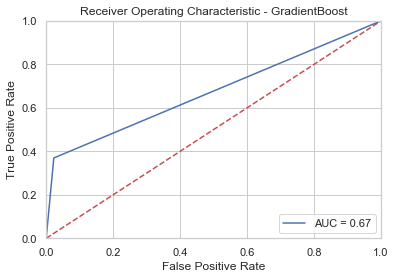

In [222]:
fpr, tpr, threshold = metrics.roc_curve([k[y] for y in y_test], [k[y1] for y1 in y_predict])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - GradientBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This model also performs much like Bagging and Ada.

**Random Forest**

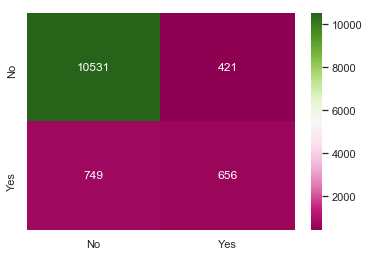

In [225]:
rfcl = RandomForestClassifier(n_estimators = 50, random_state=1,max_features=40)
rfcl = rfcl.fit(X_train, y_train)

y_predict = rfcl.predict(X_test)
cm= pd.DataFrame(metrics.confusion_matrix(y_test, y_predict), columns=['No','Yes'], index=['No','Yes'])
sns.heatmap(cm, annot=True, fmt='d', cmap="PiYG")

In [226]:
print('Accuracy of the model:', metrics.accuracy_score(y_test, y_predict))
k = {'no':0, 'yes':1}
print('Precision of the model:', metrics.precision_score([k[y] for y in y_test], [k[y1] for y1 in y_predict]))
print('Recall of the model:', metrics.recall_score([k[y] for y in y_test], [k[y1] for y1 in y_predict]))

Accuracy of the model: 0.9053168244719592
Precision of the model: 0.6090993500464252
Recall of the model: 0.4669039145907473


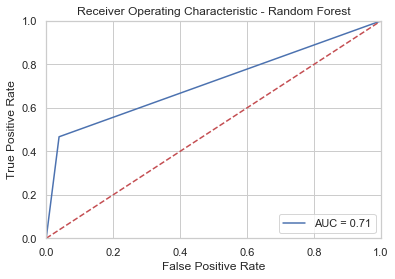

In [227]:
fpr, tpr, threshold = metrics.roc_curve([k[y] for y in y_test], [k[y1] for y1 in y_predict])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Conclusion 

The diffenrent ensemble techniques had a very close performance on this data. Only random forest had a better performance and I think it's due to the fact it comes from several weak classifiers as decision tree to reach the results.

Of course we also are dealing with an imbalanced dataset on the target variable as pointed out in EDA. The best strategy to improve this model would be to make a balanced dataset on target variable so these algorithms would not answer 'NO'for everybody.

